In [1]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import warnings
warnings.filterwarnings("ignore")
import os

# Get the current working directory
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

# Secondary Wnt drivers
This script takes the frequencies of APC genotypes in the 100KGP cohort stratified by anatomical site, sex and age, and combines them with the corresponding mutational probabilities in the healthy colon to estimate the relative cancer progression probablity of different biallelic APC genotypes, as outlined in the main text.
In particular, it generates the results discussed in section ' APC inactivation varies across anatomical sites', and plots for Figure 4 and Supplementary Figure 4.

## 1. Import data
### 1.1 Relative probabilitiy of truncating mutations by APC region
Calculated using the mutational signatures present in healthy colonic crypts (scripts and data in /Signature Analysis).
Data from Lee-Six, Henry, et al. "The landscape of somatic mutation in normal colorectal epithelial cells." Nature 574.7779 (2019): 532-537.

In [2]:
# From healthy crypts signature analysis, import the weighted probabilities of indels and stop-gained mutations in each region of APC

Region_weights=pd.read_csv(parent_dir+'/Signature Analysis/Results/All_signatures_weights.csv')


### 1.2 100KGP APC genotypes count tables
Import number of samples with different APC genotypes in the different cohorts considered. Scripts for obtaining the count tables available in the Genomics England portal. 
Data from Cornish, Alex J., et al. "Whole genome sequencing of 2,023 colorectal cancers reveals mutational landscapes, new driver genes and immune interactions." bioRxiv (2022): 2022-11.


In [3]:
KGP = pd.read_csv(parent_dir+'/Summary_Tables_100kGP/MSS_summary_Wnts.csv')
KGP ['MSS_C']=KGP ['Counts_MSS']-KGP ['Counts_P']-KGP ['Counts_D']
genes=['AMER1', 'TCF7L2', 'SOX9','FBXW7', 'BCL9','BCL9L','AXIN2','JUN']
for g in genes:
    KGP [g+'_C']=KGP [g]-KGP [g+'_P']-KGP [g+'_D']


In [4]:
# Function to generate dataset from summary tables, for bootstrapping purpose

def reproduce_dataset(original_dataframe):
    reproduced_dataset = []

    for _, row in original_dataframe.iterrows():
        entry, count = row['Type'], row['Counts']
        reproduced_dataset.extend([entry] * count)

    return pd.DataFrame({'Type': reproduced_dataset})

def dataset(gene,KGP):
    KGP_new = KGP
    Types_double=[[0],[0,0.5],[1],[1,0.5],[2],[2,0.5],[3],[3,0.5],[0,0],[0,1],[0,2],[0,3],[1,1],[1,2],[1,3],[2,2],[2,3],[3,3],]
    KGP_new['Type'] =Types_double
    KGP_new['Counts']=KGP[gene]
    KGP_new['Type'] =KGP_new['Type'].apply(tuple)

    

    return reproduce_dataset(KGP_new)

    



## 2. Calculate APC progression probabilities for each cohort
As outlined in Methods, we model biallelic APC inactivation in healthy crypts considering all main mtuation types: truncating mtuations (classified by the region relative to the number of 20AARs), copy-loss LOH and copy-neutral LOH. Using the signature analysis data, we find the prboability of each mutation, which allows calculation of biallelic genotypes.
## 2.1 Null model to calculate biallelic APC genotype probabilities

In [5]:
# Function to determine the total number of 20AARs

def aars(pr):
    if len(pr)==2:    
        if pr[1]==0.5:
            aar=pr[0]*2
        else:
            aar=sum(pr)
        
    else:
        aar=sum(pr)
    return aar

# Function to calculate the mutation probabilities of biallelic APC genotypes given mutation probabilities 

def NULL(L,I,fs,dels,cnlohs):
    L0=L[0]
    L1=L[1]
    L2=L[2]
    L3=L[3]

    I0=I[0]
    I1=I[1]
    I2=I[2]
    I3=I[3]

    m0=1
    
    # relative to m0
    
    m1=(L1*fs+(1-fs)*I1) /(L0*fs+(1-fs)*I0)
    m2=(L2*fs+(1-fs)*I2 )/(L0*fs+(1-fs)*I0)
    m3=(L3*fs+(1-fs)*I3 )/(L0*fs+(1-fs)*I0)

    md=(dels/dms)*0.5
    mn=(cnlohs/dms)

    total=(mn+md+1+m1+m2+m3)
    t=total

    m1=m1/t
    m2=m2/t
    m0=1/t
    m3=m3/t
    mn=mn/t
    md=md/t


    
    m00=m0**2
    m11=m1**2
    m22=m2**2
    m33=m3**2
    
    m01=2*m1*m0
    m02=2*m2*m0
    m03=2*m0*m3
    
    m12=2*m1*m2
    m23=2*m2*m3
    m13=2*m1*m3
    
    md0=2*m0*md
    md1=2*m1*md
    md2=2*m2*md
    md3=2*m3*md
    
    mn0=m0*mn
    mn1=m1*mn
    mn2=m2*mn
    mn3=m3*mn
    
    
    Types_double=[[0,0],[1,1],[2,2],[3,3],[0,1],[1,2],[1,3],[0,2],[2,3],[0,3],[0],[1],[2],[3],[0,0.5],[1,0.5],[2,0.5],[3,0.5]]
    aar=[]
    for t in Types_double:
        aar.append(aars(t))
        
    Types_double=['[0, 0]','[1, 1]','[2, 2]','[3, 3]','[0, 1]','[1, 2]','[1, 3]','[0, 2]','[2, 3]','[0, 3]','[0]','[1]','[2]','[3]','[0, x2]','[1, x2]','[2, x2]','[3, x2]']
    probs_double=np.asarray([m00, m11, m22, m33, m01, m12, m13, m02, m23, m03,md0,md1,md2,md3, mn0, mn1, mn2,mn3])

        

    return pd.DataFrame(data={'Genotype':Types_double,'20AARs':aar ,'Probabilities':probs_double/sum(probs_double)})#,pd.DataFrame(data={'Genotype':types,'Probabilities':probs_s/sum(probs_s)})



In [6]:
# Function to calculate the progression probabilities from mutation probabilities and frequencies of APC genotypes

def progression_probability(df,null_):
    entry_count=[]
    for t in list(null_['Type']):
        entry_count.append(len(df[df['Type'] == t]))


    null_['Counts']=entry_count
    null_['Frequency']=np.asarray(entry_count)/sum(np.asarray(entry_count))
    
    
    probs=np.asarray(null_['Frequency'])/np.asarray(null_['Probabilities'])
    probs=probs/sum(probs)
    null_['Progression']=probs
    
    return np.asarray(null_['Progression'])

# Function to calculate the number of 20AARs with maximal progression probabiliy

def max_20AARs(df,null_):
    entry_count=[]
    for t in list(null_['Type']):
        entry_count.append(len(df[df['Type'] == t]))


    null_['Counts']=entry_count
    
    
    
    nullc=null_.groupby('20AARs',as_index=False).sum()

    nullc['Frequency']=nullc['Counts']/sum(nullc['Counts'])    
    
    probs=np.asarray(nullc['Frequency'])/np.asarray(nullc['Probabilities'])
    probs=probs/sum(probs)
    
    
    nullc['Progression']=probs
    
    max_row_index = nullc['Progression'].idxmax()
    value_in_column1 = nullc.loc[max_row_index, '20AARs']
    
    
    
    return int(value_in_column1)

# Function to calculate the progression-weighted mean number of 20AARs 

def mean_20AARs(df,null_):
    entry_count=[]
    for t in list(null_['Type']):
        entry_count.append(len(df[df['Type'] == t]))


    null_['Counts']=entry_count

        
    nullc=null_.groupby('20AARs',as_index=False).sum()
    
    nullc = nullc.sort_values(by='20AARs')


    nullc['Frequency']=nullc['Counts']/sum(nullc['Counts'])
    
    
    probs=np.asarray(nullc['Frequency'])/np.asarray(nullc['Probabilities'])
    probs=probs/sum(probs)
    
    
    nullc['Progression']=probs
    mean_20AAR=0
    for a in np.arange(7):
        mean_20AAR+=a*probs[a]
        

    return mean_20AAR
        
# Function to calculate the progression probabilities from mutation probabilities and frequencies of numbers of 20AARs

def progression_probability_20AARs(df,null_):
    entry_count=[]
    for t in list(null_['Type']):
        entry_count.append(len(df[df['Type'] == t]))

    null_['Counts']=entry_count

        
    nullc=null_.groupby('20AARs',as_index=False).sum()
    
    nullc = nullc.sort_values(by='20AARs')


    nullc['Frequency']=nullc['Counts']/sum(nullc['Counts'])
    
    
    probs=np.asarray(nullc['Frequency'])/np.asarray(nullc['Probabilities'])
    probs=probs/sum(probs)
    
    
    nullc['Progression']=probs

    return np.asarray(   nullc['Progression'])

    
# Functions to find CI by bootstrapping

def bootstrap_func_values(dataframe, func, n_iterations, confidence_level,**kwargs):
 
    # Extract the specified column from the DataFrame
    values = dataframe['Type'].values
    try:
        N=len(func(dataframe,**kwargs))
    except TypeError:
    # Handle the TypeError by returning '1'
        N= 1

    # Initialize arrays to store the bootstrapped values for each iteration
    bootstrapped_values = np.zeros((n_iterations, N))

    # Perform bootstrapping
    for i in range(n_iterations):
        # Generate a bootstrap sample with replacement
        bootstrap_sample = pd.DataFrame({'Type': np.random.choice(values, size=len(values), replace=True)})

        a=func(bootstrap_sample,**kwargs)
        
        # Compute the desired values using the user-defined function with parameters
        bootstrapped_values[i, :] = func(bootstrap_sample,**kwargs)

    # Compute mean values for each iteration
    mean_values = np.mean(bootstrapped_values, axis=0)

    # Compute confidence intervals for each iteration
    alpha = (1 - confidence_level) / 2
    ci_lower_values = np.percentile(bootstrapped_values, alpha * 100, axis=0)
    ci_upper_values = np.percentile(bootstrapped_values, (1 - alpha) * 100, axis=0)

    return bootstrapped_values
## Define functions to calculate mean progression probabilities and perform statistical analysis

# Permutation test for difference in mean progression probability
def mean_p_val(set1,set2,K):
    
    '''
        set1: first data set
        set2: second data set
        data: all the tumours
        K: number of runs
        
        '''

    
     # find the difference  in probabilities (scaled by probability of 0 20AARs)
    diff=mean_20AARs(set1,null)-mean_20AARs(set2,null)
    
    # find length of set 1
    NP=len(set1)
    
    
    
    # re_index total data to avoid issues with pandas
    set1=set1.reset_index(drop=True)
    set2=set2.reset_index(drop=True)
    data=pd.concat([set1,set2])

    data=data.reset_index(drop=True)

    
    # start list 
    difference=[]
    # for as many runs as chosen,
    for k in np.arange(K):
        
        keep=np.random.choice(np.arange(len(data)-1),replace=False,size=NP)
        df_new=data.iloc[keep]
        notin=[]

        for i in np.arange(len(data)-1):
            if i not in keep:
                notin.append(i)
        df_compliment=data.iloc[notin]
        df_new=df_new.reset_index()  
        df_compliment=df_compliment.reset_index()  
        
         
        # store the difference in mean 20AARs of each set
        difference.append(abs(mean_20AARs(df_new,null)-mean_20AARs(df_compliment,null)))
        
  
    pval=sum(difference>abs(diff))/len(difference)

    
    
    
    return diff, pval


# Functions to find CI by bootstrapping

def bootstrap_func_values_ci(dataframe, func, n_iterations, confidence_level,**kwargs):
    # Extract the specified column from the DataFrame
    values = dataframe['Type'].values
    try:
        N=len(func(dataframe,**kwargs))
    except TypeError:
    # Handle the TypeError by returning '1'
        N= 1

    # Initialize arrays to store the bootstrapped values for each iteration
    bootstrapped_values = np.zeros((n_iterations, N))

    # Perform bootstrapping
    for i in range(n_iterations):
        # Generate a bootstrap sample with replacement
        bootstrap_sample = pd.DataFrame({'Type': np.random.choice(values, size=len(values), replace=True)})

        a=func(bootstrap_sample, **kwargs)
        
        # Compute the desired values using the user-defined function with parameters
        bootstrapped_values[i, :] = func(bootstrap_sample,**kwargs)

    # Compute mean values for each iteration
    mean_values = np.mean(bootstrapped_values, axis=0)

    # Compute confidence intervals for each iteration
    alpha = (1 - confidence_level) / 2
    ci_lower_values = np.percentile(bootstrapped_values, alpha * 100, axis=0)
    ci_upper_values = np.percentile(bootstrapped_values, (1 - alpha) * 100, axis=0)

    return mean_values, ci_lower_values, ci_upper_values
def mean_weighted(df):
    
    P_WNT=df[ df['WNT']==1].reset_index(drop=True)
    P_WNT=P_WNT[ P_WNT['PR']==1].reset_index(drop=True)
    
    P_WT=df[ df['WNT']==0].reset_index(drop=True)
    P_WT=P_WT[ P_WT['PR']==1].reset_index(drop=True)
    
    D_WNT=df[ df['WNT']==1].reset_index(drop=True)
    D_WNT=D_WNT[ D_WNT['PR']==0].reset_index(drop=True)
    
    D_WT=df[ df['WNT']==0].reset_index(drop=True)
    D_WT=D_WT[ D_WT['PR']==0].reset_index(drop=True)
    
    
    WNT=df[ df['WNT']==2].reset_index(drop=True)
    WT=df[ df['WNT']==-2].reset_index(drop=True)
    
    
    a=len(P_WT)
    b=len(D_WT)
    c=len(P_WNT)
    d=len(D_WNT)
    if c+d==0:
        c=1
    e=len(WNT) 
    
    difference_Proximal = mean_20AARs(P_WNT,null) - mean_20AARs(P_WT,null)
    difference_Distal = mean_20AARs(D_WNT,null) - mean_20AARs(D_WT,null)
    difference_Colon = mean_20AARs(WNT,null) - mean_20AARs(WT,null)
    
    weighted = (difference_Proximal*c + difference_Distal * d + difference_Colon* e)/(c+d+e)

        
    return weighted

def mean_unweighted(df):
    
    WNT=df[ df['WNT']==1].reset_index(drop=True)
    WT=df[ df['WNT']==0].reset_index(drop=True)
    
    
    mc=mean_20AARs(WNT,null)
    md=mean_20AARs(WT,null)
  
    
    return mc-md


def bootstrap_func_values_one(dataframe, func, n_iterations, ci,**kwargs):
    n_size = len(dataframe)

    # Initialize arrays to store the bootstrapped values for each iteration
    bootstrapped_values = np.zeros((n_iterations))

    # Perform bootstrapping
    for i in range(n_iterations):
        # Generate a bootstrap sample with replacement
        bootstrap_sample = dataframe.sample(n=n_size, replace=True)

        a=func(bootstrap_sample, **kwargs)
        
        # Compute the desired values using the user-defined function with parameters
        bootstrapped_values[i] = func(bootstrap_sample,**kwargs)

    # Compute mean values for each iteration
    mean_values = np.mean(bootstrapped_values, axis=0)

    # Compute confidence intervals for each iteration
    lower_bound = np.percentile(bootstrapped_values, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrapped_values, 100 - (100 - ci) / 2)

    return np.mean(bootstrapped_values), lower_bound, upper_bound



def bootstrap(data,func,n,confidence_level):
    results=[]
    for i in np.arange(n):
        sample=data.sample(n=len(data),replace=True)
        result=func(sample)
        results.append(result)
        
    # Compute mean values for each iteration
    mean_values = np.mean(results, axis=0)

    # Compute confidence intervals for each iteration
    alpha = (1 - confidence_level) / 2
    ci_lower_values = np.percentile(results, alpha * 100, axis=0)
    ci_upper_values = np.percentile(results, (1 - alpha) * 100, axis=0)

    
    return mean_values,ci_lower_values,ci_upper_values




In [7]:
def delta_Wnts(gene,n):

    # with no site correction
    
    df_MSS=dataset('Counts_MSS',KGP)
    df_P=dataset('Counts_P',KGP)
    df_D=dataset('Counts_P',KGP)

    
    
    df_WP=dataset(    gene+'_P',KGP)
    df_WD=dataset(    gene+'_D',KGP)
    df_W=dataset(    gene,KGP)
    
    
    
    delta,pval=mean_p_val(df_W,df_MSS,10)
    
    # 
    no_wnt=np.zeros(len(df_MSS))
    wnt=np.ones(len(df_W))
    df_MSS['WNT']=no_wnt
    df_W['WNT']=wnt
    
    combined = pd.concat([df_MSS, df_W])
    
    
    cd ,cdl,cdh = bootstrap(combined,mean_unweighted,n,0.95)

    # with site correction

    # with site correction
    df_MSS=dataset('MSS_C',KGP)
    df_P=dataset('Counts_P',KGP)
    df_D=dataset('Counts_D',KGP)
    
    df_WP=dataset(    gene+'_P',KGP)
    df_WD=dataset(    gene+'_D',KGP)
    df_W=dataset(    gene+'_C',KGP)
    
    
    wnt=np.ones(len(df_WD))
    pr=np.zeros(len(df_WD))
    
    df_WD['WNT']=wnt
    df_WD['PR']=pr
        
    wnt=np.ones(len(df_WP))
    pr=np.ones(len(df_WP))
    df_WP['WNT']=wnt
    df_WP['PR']=pr
    
    wnt=np.zeros(len(df_D))
    pr=np.zeros(len(df_D))
    df_D['WNT']=wnt
    df_D['PR']=pr
        
    wnt=np.zeros(len(df_P))
    pr=np.ones(len(df_P))
    df_P['WNT']=wnt
    df_P['PR']=pr
    
    
    no_wnt=np.zeros(len(df_MSS))
    wnt=np.ones(len(df_W))
    df_MSS['WNT']=no_wnt-2
    df_W['WNT']=wnt+1
    df_MSS['PR']=no_wnt+2
    df_W['PR']=wnt+2
    
    
    combined_ = pd.concat([df_WD, df_WP, df_D, df_P, df_W, df_MSS])
#
    
    wm,wdl,wdh=bootstrap(combined_,mean_weighted,n,0.95)

    
    if np.isnan(wm):
        wm,wdl,wdh=cd ,cdl,cdh

    

    return    delta,pval, gene,cd ,cdl,cdh, wm,wdl,wdh
    

    






    

    

In [8]:
## Calculate mutation probabilities using signature data in distal crypts

# Find weight per region for stop_gained mutations
L=Region_weights['SBS_healthy']
# Find weight per region for frameshift mutations
I=Region_weights['IDS_healthy']
L=np.asarray(L)/sum(np.asarray(L))
I=np.asarray(I)/sum(np.asarray(I))

fs=1 - 3/7 # Probabilty of frameshifts, MSS
dms =0.22875816993464052 # relative proportion of double mutants, copy-loss and copy-neutral LOH
dels= 0.5882352941176471
cnlohs= 0.1830065359477124


# Build null model using the signatures in healthy crypts
null=NULL(L,I,fs,dels,cnlohs)

Types_double=[[0,0],[1,1],[2,2],[3,3],[0,1],[1,2],[1,3],[0,2],[2,3],[0,3],[0],[1],[2],[3],[0,0.5],[1,0.5],[2,0.5],[3,0.5]]
null['Type'] =Types_double
null['Type'] =null['Type'].apply(tuple)


In [9]:

## Combine dataset of APC genotypes in proximal CRCs with null model to calculate progression probabilities
df_AMER1=dataset('AMER1',KGP)
px_mD,lx_mD,hx_mD = bootstrap_func_values_ci(df_AMER1, progression_probability_20AARs, 1000, 0.95,null_=null)

# Bootstrapping of  progression-weighted mean number of 20AARs 
MeanP,MlmD,MhmD = bootstrap_func_values_ci(df_AMER1, mean_20AARs, 1000, 0.95,null_=null)
print('Progression-weighted mean number of total retained 20AARs in AMER1, 100KGP cohort:',MeanP, ', 95% CI', MlmD,MhmD)


## Combine dataset of APC genotypes in proximal CRCs with null model to calculate progression probabilities
df_TCF7L2=dataset('TCF7L2',KGP)
px_T,lx_T,hx_T = bootstrap_func_values_ci(df_TCF7L2, progression_probability_20AARs, 1000, 0.95,null_=null)

# Bootstrapping of  progression-weighted mean number of 20AARs 
MeanD,MlmD,MhmD = bootstrap_func_values_ci(df_TCF7L2, mean_20AARs, 1000, 0.95,null_=null)
print('Progression-weighted mean number of total retained 20AARs in TCF7L2, 100KGP cohort:',MeanD, ', 95% CI', MlmD,MhmD)


## Combine dataset of APC genotypes in proximal CRCs with null model to calculate progression probabilities
df_MSS=dataset('Counts_MSS',KGP)
px_M,lx_M,hx_M = bootstrap_func_values_ci(df_MSS, progression_probability_20AARs, 1000, 0.95,null_=null)
MeanM,MlmM,MhmM = bootstrap_func_values_ci(df_TCF7L2, mean_20AARs, 1000, 0.95,null_=null)


Progression-weighted mean number of total retained 20AARs in AMER1, 100KGP cohort: [4.08717515] , 95% CI [3.48332398] [4.50955466]
Progression-weighted mean number of total retained 20AARs in TCF7L2, 100KGP cohort: [1.80401573] , 95% CI [1.65248242] [1.95165638]


[2.28044871]
[-0.0027107]


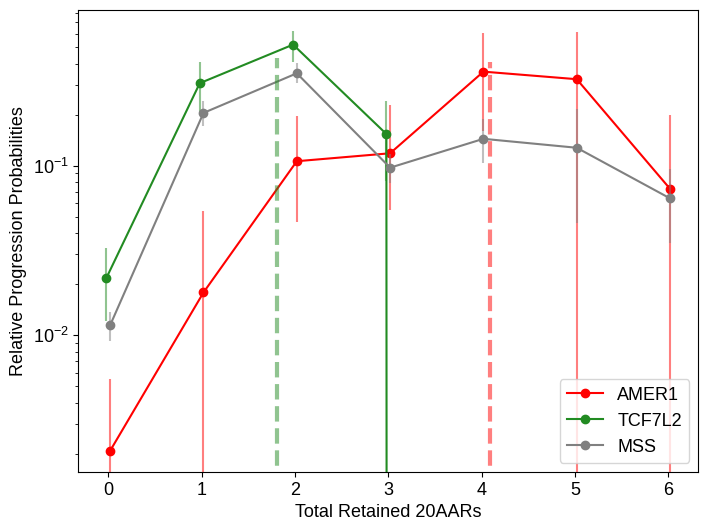

In [10]:

plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 13})
plt.rcParams['font.family'] = 'Liberation Sans'

plt.plot(np.arange(7)+0.02,px_mD,'o-',color='red',label='AMER1')
plt.vlines(np.arange(7)+0.02,lx_mD,hx_mD,color='red',alpha=0.5)#

plt.vlines(np.arange(7)-0.02,lx_T,hx_T,color='forestgreen',alpha=0.5)#

plt.plot(np.arange(7)-0.02,px_T,'o-',color='forestgreen',label='TCF7L2')



plt.plot(np.arange(7)+0.02,px_M,'o-',color='grey',label='MSS')
plt.vlines(np.arange(7)+0.02,lx_M,hx_M,color='grey',alpha=0.5)#

plt.vlines(MeanP,0,0.4081,color='red',linewidth=3,alpha=0.5,linestyle='dashed')#

plt.vlines(MeanD,0,0.43,color='forestgreen',linewidth=3,alpha=0.5,linestyle='dashed')#

plt.legend()
plt.yscale('log')
plt.xlabel('Total Retained 20AARs')
plt.ylabel('Relative Progression Probabilities')
plt.legend()

#plt.savefig('Results/Prox_dist.svg',dpi=300)
delta=MeanP-MeanM
print(delta)
delta=MeanD-MeanM
print(delta)

In [11]:
deltas=[]
ps=[]
cLow=[]
cHigh=[]
deltas_uncorrected=[]
genes=['AMER1', 'TCF7L2', 'SOX9','FBXW7', 'BCL9','BCL9L','AXIN2','JUN']

for g in genes:
    d,p,g,dd,cl,ch,dc,clc,chc=delta_Wnts(g,500)
    deltas.append(d)
    deltas_uncorrected.append(dd)
    ps.append(p)
    cLow.append(cl)
    cHigh.append(ch)


In [13]:
genes=['AMER1','SOX9','TCF7L2','BCL9','BCL9L','FBXW7']
deltas=[]
ps=[]
cLow=[]
cHigh=[]
deltas_corrected=[]
cL=[]
cH=[]
for g in genes:
    d,p,g,dd,cl,ch,dc,clc,chc=delta_Wnts(g,200)
    deltas.append(d)
    ps.append(p)
    deltas_corrected.append(dc)
    cL.append(clc)
    cH.append(chc)

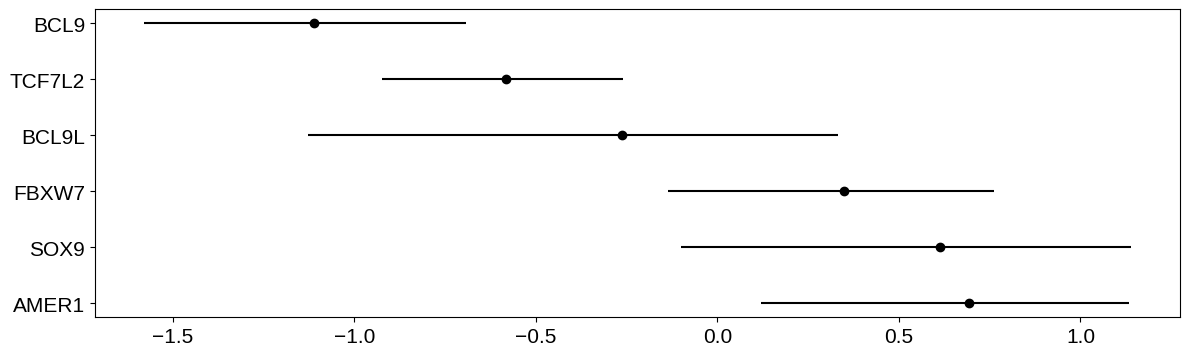

In [14]:

plt.figure(figsize=(14,4))
plt.rcParams.update({'font.size': 15})
indi=np.argsort(deltas_corrected)[::-1]
for i in indi:
    plt.plot(deltas_corrected[i],genes[i],'ko',label='Corrected')
    plt.hlines(genes[i],cL[i],cH[i],color='black')
plt.savefig('wnts_corr.svg',bbox_inches='tight',dpi=300)

### Save all results

In [13]:
data=pd.DataFrame(data={'Subtype':subtype,'Progression-Weighted Mean 20AAR':means ,'CLow':clow, 'CHigh':chigh})#,pd.DataFrame(data={'Genotype':types,'Probabilities':probs_s/sum(probs_s)})
data.to_csv('Results/Mean20AARs_results.csv')
data=pd.DataFrame(data={'Comparison':difference,'Delta':deltas ,'p-val':pvals})#,pd.DataFrame(data={'Genotype':types,'Probabilities':probs_s/sum(probs_s)})
data.to_csv('Results/Mean20AARs_results2.csv')